<a href="https://colab.research.google.com/github/jchzener/Algorithms-Notebooks/blob/master/discrete_2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here, we implement one-step actor-critic with neural networks and test it on a simple 2D reaching environment. We will start with the environment first. The agent is confined in a 2D arena defined by state $S \in [-1, +1]^2$. An example of states is then $[0.5, -0.2]^\top$. Agent has eight actions available that change the state by one of following eight possible increments $f(A)$: $[-b, -b], [-b, 0], [-b, 1], [0, -b], [0, 0], [0, b], [b, -b], [b, 0], \text{ and } [b, b]$, where $b>0$ is a small scalar. After choosing an action $A_t$, the state is changed as follows: $S_{t+1} = S_t + f(A_t)$, except when the state goes outside the arena, in which case it remains within the arena.

It is an episodic task. Each episode, the agent is spawned from a uniformly randomly drawn state from the arena. The episode terminates when the agent reaches a small square around $(0, 0)$. The goal of the agent is to reach the terminal state as soon as possible. We formulate this goal by giving $-1$ rewards every time step.

tensor([[-11.8832]], grad_fn=<AddmmBackward>)
1 1240
tensor([[-10.8438]], grad_fn=<AddmmBackward>)
2 1168
tensor([[-10.7115]], grad_fn=<AddmmBackward>)
3 1570
tensor([[-9.8414]], grad_fn=<AddmmBackward>)
4 2
tensor([[-5.1522]], grad_fn=<AddmmBackward>)
5 194
tensor([[-7.4525]], grad_fn=<AddmmBackward>)
6 1358
tensor([[-5.2711]], grad_fn=<AddmmBackward>)
7 53
tensor([[-4.2641]], grad_fn=<AddmmBackward>)
8 220
tensor([[-3.6761]], grad_fn=<AddmmBackward>)
9 167
tensor([[-5.5003]], grad_fn=<AddmmBackward>)
10 638
tensor([[-3.4069]], grad_fn=<AddmmBackward>)
11 220
tensor([[-3.5879]], grad_fn=<AddmmBackward>)
12 92
tensor([[-2.9340]], grad_fn=<AddmmBackward>)
13 198
tensor([[-1.9756]], grad_fn=<AddmmBackward>)
14 134
tensor([[-2.3595]], grad_fn=<AddmmBackward>)
15 329
tensor([[-2.0275]], grad_fn=<AddmmBackward>)
16 147
tensor([[-1.7982]], grad_fn=<AddmmBackward>)
17 210
tensor([[-1.6946]], grad_fn=<AddmmBackward>)
18 177
tensor([[-1.8542]], grad_fn=<AddmmBackward>)
19 233
tensor([[-2.0966]]

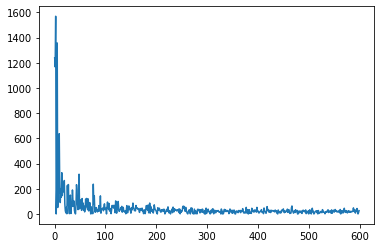

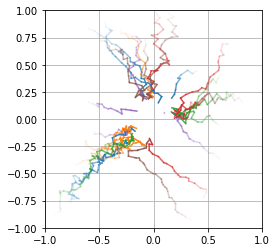

In [ ]:
# Actor critic agent
%reset -f
import torch as tor
import matplotlib.pyplot as plt


# Problem
tor.manual_seed(1)
nacts = 8
aval = 0.03*tor.tensor([
    [-1, -1], [-1, 0], [-1, 1], [0, -1], [0, 0], [0, 1], [1, -1], [1, 0], [1, 1]
], dtype=tor.float32)
LB = tor.tensor([-1., -1.]) 
UB = tor.tensor([1., 1.])

# Agent
nhid = 10
alpha = 0.0003
actor_body = tor.nn.Sequential(tor.nn.Linear(2, nhid), tor.nn.ReLU(),
                               tor.nn.Linear(nhid, nhid), tor.nn.ReLU()
                               )
actor_pref = tor.nn.Sequential(tor.nn.Linear(nhid, nacts))
actor_pref[-1].weight.data[:] = 0; actor_pref[-1].bias.data[:] = 0
critic = tor.nn.Sequential(tor.nn.Linear(2, nhid), tor.nn.ReLU(),
                           tor.nn.Linear(nhid, nhid), tor.nn.ReLU(),
                          tor.nn.Linear(nhid, 1))
popt = tor.optim.Adam(list(actor_body.parameters())+list(actor_pref.parameters()),lr=alpha)
copt = tor.optim.Adam(critic.parameters(), lr=10*alpha)

# Experiment
EP = 600
rets = []
Slogs = []
i = 0
for ep in range(EP):
    Slogs.append([])
    S = tor.rand((1, 2))*(UB-LB) + LB
    Slogs[-1].append(S)
    ret = 0
    while True:
        # Take action
        feat = actor_body(S)
        pref = actor_pref(feat)
        try:
            pol = tor.distributions.Categorical(logits=pref)
        except:
            print("E", pref)
        Ai = pol.sample()

        # Receive reward and next state
        noise = tor.rand(2)*0.06-0.03
        SP = tor.clamp(S + aval[Ai] + noise, LB, UB)
        R = -0.01

        # Learning
        done = tor.allclose(SP, tor.zeros(2), atol=0.2)
        vs = critic(S); vsp = critic(SP)
        pobj = pol.log_prob(Ai)*(R + (1-done)*vsp - vs).detach()
        ploss = -pobj
        closs = (R + (1-done)*vsp.detach() - vs)**2
        popt.zero_grad()
        ploss.backward()
        popt.step()
        copt.zero_grad()
        closs.backward()
        copt.step()

        # Log
        Slogs[-1].append(SP)
        ret += R

        # Termination
        if done:
            print(vsp)
            rets.append(ret)
            i += 1
            print(i, len(Slogs[-1]))
            break
        S = SP

# Plotting
plt.plot(-100*tor.tensor(rets))
plt.figure()

colors = ["tab:blue", "tab:green", "tab:orange", "tab:purple", "tab:red", "tab:brown"]
for i in range(-min(30, EP), 0):
    color = colors[i%len(colors)]
    Slog = tor.cat(Slogs[i])
    for i in range(Slog.shape[0]-1):
        plt.plot(Slog[i:i+2,0], Slog[i:i+2,1], alpha=(i+1)/Slog.shape[0], color=color)
plt.xlim([LB[0], UB[0]])
plt.ylim([LB[1], UB[1]])
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
plt.show()
